# FFT

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Appendix A

Copyright 2017 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import os
import string
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import thinkplot

import matplotlib.pyplot as plt

### Empirical order of growth

Sometimes we can figure out what order of growth a function belongs to by running it with a range of problem sizes and measuring the run time.

To measure runtimes, we'll use `etime`, which uses `os.times` to compute the total time used by a process, including "user time" and "system time".  User time is time spent running your code; system time is time spent running operating system code on your behalf.

In [2]:
def etime():
    """Measures user and system time this process has used.

    Returns the sum of user and system time."""
    user, sys, chuser, chsys, real = os.times()
    return user+sys

`time_func` takes a function object and a problem size, `n`, runs the function, and returns the elapsed time.

In [3]:
def time_func(func, n):
    """Run a function and return the elapsed time.
    
    func: function
    n: problem size
    
    returns: user+sys time in seconds
    """
    start = etime()
    func(n)
    end = etime()
    elapsed = end - start
    return elapsed

`run_timing_test` takes a function, runs it with a range of problem sizes, and returns two lists: problem sizes and times.

In [4]:
def run_timing_test(func, max_time=1):
    """Tests the given function with a range of values for n.
    
    func: function object

    returns: list of ns and a list of run times.
    """
    ns = []
    ts = []
    for i in range(6, 28):
        n = 2**i
        t = time_func(func, n)
        print(n, t)
        if t > 0:
            ns.append(n)
            ts.append(t)
        if t > max_time:
            break

    return ns, ts

`fit` takes the lists of ns and ts and fits it with a curve of the form `a * n**exp`, where `exp` is a given exponent and `a` is chosen so that the line goes through a particular point in the sequence, usually the last. 

In [5]:
def fit(ns, ts, exp=1.0, index=-1):
    """Fits a curve with the given exponent.
    
    ns: sequence of problem sizes
    ts: sequence of times
    exp: exponent of the fitted curve
    index: index of the element the fitted line should go through
    
    returns: sequence of fitted times

    
    """
    # Use the element with the given index as a reference point, 
    # and scale all other points accordingly.
    nref = ns[index]
    tref = ts[index]

    tfit = []
    for n in ns:
        ratio = n / nref
        t = ratio**exp * tref
        tfit.append(t)

    return tfit

`plot_timing_test` plots the results.

In [6]:
def plot_timing_test(ns, ts, label='', color='blue', exp=1.0, scale='log'):
    """Plots data and a fitted curve.

    ns: sequence of n (problem size)
    ts: sequence of t (run time)
    label: string label for the data curve
    color: string color for the data curve
    exp: exponent (slope) for the fitted curve
    """
    tfit = fit(ns, ts, exp)
    plt.plot(ns, tfit, color='0.7', linewidth=2, linestyle='dashed')
    plt.plot(ns, ts, 's-', label=label, color=color, alpha=0.5, linewidth=3)
    plt.xlabel('Problem size (n)')
    plt.ylabel('Runtime (seconds)')
    plt.xscale(scale)
    plt.yscale(scale)
    plt.legend()

For small values of `n`, the runtime is so short that we're probably not getting an accurate measurement of just the operation we're interested in.  But as `n` increases, runtime seems to converge to a line with slope 1.  

That suggests that performing append `n` times is linear, which suggests that a single append is constant time.  

### DFT

Here's an implementation of DFT using outer product to construct the transform matrix, and dot product to compute the DFT.

In [7]:
PI2 = 2 * np.pi

def dft(xs):
    N = len(xs)
    ns = np.arange(N) # N # 0.0 ... 1.0, samples
    ks = np.arange(N) # 0 ... N, frequency buckets
    args = np.outer(ks, ns) # [0 0 0] [0 .33 .66] [0 .66 1.33], rows are the samples, columns are the frequencies
    M = np.exp(-1j * PI2 * args)
    amps = M.dot(xs)
    return amps

Here's an example comparing this implementation of DFT with `np.fft.fft`

True

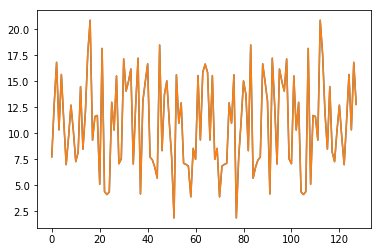

In [8]:
xs = np.random.normal(size=128)
spectrum1 = np.fft.fft(xs)
plt.plot(np.abs(spectrum1))

spectrum2 = dft(xs)
plt.plot(np.abs(spectrum2))

np.allclose(spectrum1, spectrum2)

Now, let's see what the asymptotic behavior of `np.fft.fft` looks like:

64 0.0
128 0.010000000000000231
256 0.0
512 0.0
1024 0.0
2048 0.0
4096 0.0
8192 0.0
16384 0.0
32768 0.0
65536 0.009999999999999787
131072 0.029999999999999805
262144 0.050000000000000266
524288 0.10999999999999943
1048576 0.23000000000000043
2097152 0.5099999999999998
4194304 1.0099999999999998


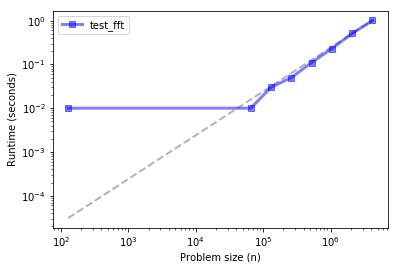

In [9]:
def test_fft(n):
    xs = np.random.normal(size=n)
    spectrum = np.fft.fft(xs)

ns, ts = run_timing_test(test_fft)
plot_timing_test(ns, ts, 'test_fft', exp=1)

Up through the biggest array I can handle on my computer, it's hard to distinguish from linear.

And let's see what my implementation of DFT looks like: 

64 0.009999999999999787
128 0.010000000000000675
256 0.020000000000000462
512 0.040000000000000036
1024 0.17999999999999972
2048 0.589999999999999
4096 1.8900000000000006


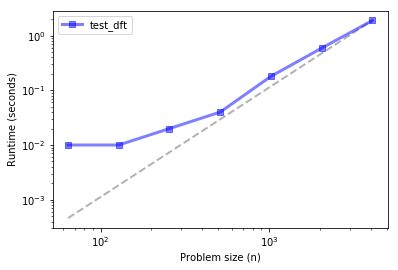

In [10]:
def test_dft(n):
    xs = np.random.normal(size=n)
    spectrum = dft(xs)

ns, ts = run_timing_test(test_dft)
plot_timing_test(ns, ts, 'test_dft', exp=2)

It's definitely much slower than `np.fft.fft`.

But it looks like it's not as bad as quadratic.  Maybe it's linear?

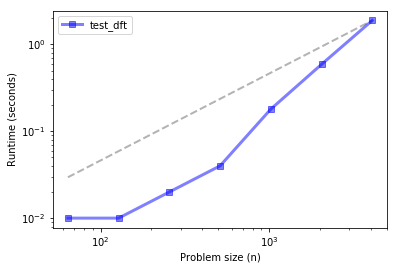

In [11]:
plot_timing_test(ns, ts, 'test_dft', exp=1)

No, it looks steeper than linear.  Just based on this data, we would have a hard time classifying this algorithm.

### Implementing FFT

Ok, let's try our own implementation of FFT.

First I'll get the divide and conquer part of the algorithm working:

In [12]:
def fft_norec(ys):
    N = len(ys)
    He = dft(ys[::2]) # evens
    Ho = dft(ys[1::2])# odds
    
    ns = np.arange(N)
    W = np.exp(-1j * PI2 * ns / N)
    
    return np.tile(He, 2) + W * np.tile(Ho, 2) # Danielson-Lanczos Lemma

This version breaks the array in half, uses `dft` to compute the DFTs of the halves, and then uses the D-L lemma to stich the results back up.

Let's see what the performance looks like.

64 0.0
128 0.009999999999999787
256 0.0
512 0.040000000000000924
1024 0.07000000000000028
2048 0.2699999999999996
4096 0.9199999999999999
8192 4.98


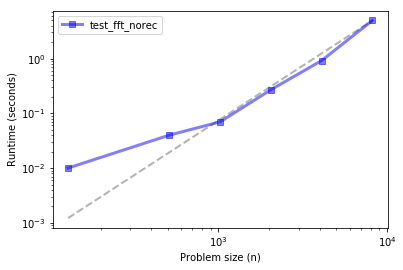

In [13]:
def test_fft_norec(n):
    xs = np.random.normal(size=n)
    spectrum = fft_norec(xs)

ns, ts = run_timing_test(test_fft_norec)
plot_timing_test(ns, ts, 'test_fft_norec', exp=2)

Looks about the same as DFT.  Again, it seems better than quadratic, but not as good as linear.

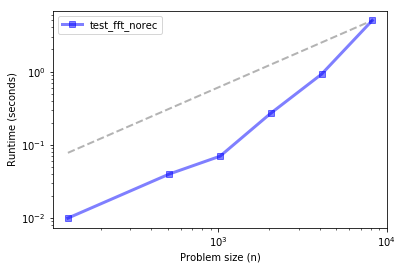

In [14]:
plot_timing_test(ns, ts, 'test_fft_norec', exp=1)

**Exercise:**  Starting with fft_norec, write a function called fft_rec that's fully recursive; that is, instead of using `dft` to compute the DFTs of the halves, it should use `fft_rec`.  Of course, you will need a base case to avoid an infinite recursion.  You have two options:

1) The DFT of an array with length 1 is the array itself.

2) If the parameter, `ys`, is smaller than some threshold length, you could use DFT.

Use `test_fft_rec`, below, to check the performance of your function.

In [17]:
def fft_rec(ys):
    N = len(ys)
    if N > 1:
        evens = ys[::2]
        He = fft_rec(evens)
        
        odds = ys[1::2]
        Ho = fft_rec(odds)

        ns = np.arange(N)
        W = np.exp(-1j * PI2 * ns / N)

        return np.tile(He, 2) + W * np.tile(Ho, 2) # Danielson-Lanczos Lemma
    
    return ys[0]

In [18]:
xs = np.random.normal(size=128)
spectrum1 = np.fft.fft(xs)

spectrum2 = fft_rec(xs)

np.allclose(spectrum1, spectrum2)

True

64 0.010000000000001563
128 0.0
256 0.0
512 0.019999999999999574
1024 0.019999999999999574
2048 0.10999999999999943
4096 0.17999999999999972
8192 0.3999999999999986
16384 0.4800000000000004
32768 0.7600000000000016
65536 1.5599999999999987


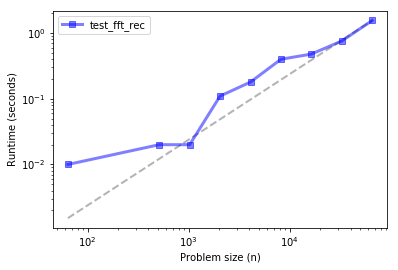

In [19]:
def test_fft_rec(n):
    xs = np.random.normal(size=n)
    spectrum = fft_rec(xs)

ns, ts = run_timing_test(test_fft_rec)
plot_timing_test(ns, ts, 'test_fft_rec', exp=1)

If things go according to plan, your FFT implementation should be faster than `dft` and `fft_norec`, but probably not as fast as `np.fft.fft`.  And it will probably be a bit steeper than linear.